## ProtVec + RNN

In [ ]:
import numpy as np
import pandas as pd

df = pd.read_parquet('Metal_all_20180116.snappy.parquet')
# print ('***** Data Types *****' + '\n' + str(df.dtypes) + '\n\n' + 
#        '***** Unique Ligands *****' + '\n' + str(df.ligandId.unique()))

# Extract zinc-binded, single-chained protein sequences
df_zn = df.loc[df['ligandId'] == 'ZN']
df_zn_single = df_zn.loc[df_zn['interactingChains'] == 1]
seqs = np.array(df_zn_single.sequence)
target = np.array(df_zn_single.fingerprint)

del df,df_zn,df_zn_single

#### (Buggy) Construct dict from seqs without U,X

In [ ]:
# Remove seqs containing 'U' and 'X'
rows_to_delete = []
for i in range(seqs.shape[0]):
    if 'X' in seqs[i] or 'U' in seqs[i]:
#         print('Removing...' + str(i))
        rows_to_delete.append(i)        
        
seqs = np.delete(seqs, rows_to_delete, 0)
target = np.delete(target, rows_to_delete)
print ("Sequence length is " + str(seqs.shape[0]))

### Get vector representation of sequences

In [15]:
n_gram_size = 3
dimension = 100

# Filepaths
dict_path = "./dictionaries/"
model_path = "./models/"
hist_path = "./histories/"


# Whether to use simple onehot encoding for inputs
UseOnehot = False
UseReplicate = True


In [3]:
# Load
seqs_dict = {}
with open(dict_path + "seq_n_gram_to_vec_dict_w_UX", 'r') as fp:
        seqs_dict = json.load(fp)

#### Input onehot encoding

In [ ]:
onehot_keys = []
for i in range(seqs.shape[0]):
    for j in range(len(seqs[i])):
        if seqs[i][j] not in onehot_keys:
            onehot_keys.append(seqs[i][j])
# import operator
# print (sorted(seqs_dict_onehot.items(), key=operator.itemgetter(1)))
onehot_keys = np.array(onehot_keys).reshape(-1)
np.random.shuffle(onehot_keys)

seqs_dict_onehot = {}
onehot_matrix = np.eye(onehot_keys.shape[0])
for i in range(onehot_keys.shape[0]):
    seqs_dict_onehot[onehot_keys[i]] = onehot_matrix[i].tolist()

In [16]:
seqs_dict_onehot = {}
with open(dict_path + "seqs_dict_onehot", 'r') as fp:
        seqs_dict_onehot = json.load(fp)

In [ ]:
if UseOnehot:
    n_gram_size = 1
    dimension = onehot_keys.shape[0]
    seqs_dict = seqs_dict_onehot

### Construct feature vector

In [ ]:
# Data from previous sections
# seqs, target, seqs_dict
# dimension

In [ ]:
import matplotlib.pyplot as plt

# Plot distribution of sequence lengths
lengths = []
for item in seqs:
    lengths.append(len(item))

fig = plt.figure(0)
ax = fig.add_subplot(111)
ax.set_title('Sequence Length Distribution')
n, bins, rectangles = ax.hist(lengths, 200)
fig.canvas.draw()
plt.show()

In [4]:
# Onehot encoding given a cutoff (Padded with 0s / Replicate partial sequence at the end)
def to_onehot(target_single, cutoff, seq_size, replicate=False):
    t = [0] * cutoff
    offset = cutoff - seq_size
    for i in target_single:
        t[i] = 1 
        if replicate and (i >= seq_size-offset) and (i < seq_size):
            t[offset+i] = 1
    return t

# Convert n-gram to vector given a dictionary
def to_vector(seqs_dict, seq, index, n_gram_size, dimension):
    if (index+n_gram_size) < len(seq):
        word = seq[index: index+n_gram_size]
        if '0' not in word:
            if word in seqs_dict.keys():
                return seqs_dict[word]
    return [0] * dimension

# Discard sequences longer than the cutoff and reconstruct datasets
def optimal_cutoff(seqs, target, cutoff, replicate=False):
    new_seqs = []
    new_target = []
    new_lengths = []
    for i, s, t in zip(range(seqs.shape[0]), seqs, target):
        if len(s) <= cutoff:
            if replicate:
                offset = cutoff-len(s)
                s = s + s[len(s)-offset : len(s)]
                new_seqs.append(s)
            else:
                new_seqs.append(s + (cutoff-len(s)) * '0')
            new_target.append(to_onehot(t,cutoff,len(s), replicate))
            new_lengths.append(len(s))
    return new_seqs, new_target, new_lengths

# Construct input tensor (Num_Samples x Cutoff X Dimension)
def construct_X(seqs_dict, seqs, cutoff, n_gram_size, dimension, sample_size, start_index):
    X = np.zeros((sample_size, cutoff, dimension))
    for i in range(sample_size):
        for j in range(cutoff):
            X[i][j] = np.array(to_vector(seqs_dict, seqs[start_index + i], j, n_gram_size, dimension))
    return X

# Get a pair of inputs for testing
def randomSample(X, Y):
    size = X.shape[0]
#     print (X.shape)
#     print (Y.shape)
    r = np.random.randint(size)
    retX = X[r].reshape((1, X.shape[1], X.shape[2]))
    retY = Y[r].reshape((1, Y.shape[1]))
    return (retX, retY)

# Paired randomization 
def shuffleXY(X, Y):
    C = list(zip(X, Y))
    random.shuffle(C)
    X_ret, Y_ret = zip(*C)
    return X_ret, Y_ret

In [5]:
lengths = np.zeros(len(seqs))
for i in range(len(seqs)):
    lengths[i] = len(seqs[i])

cutoff = int(np.mean(lengths) + 2 * np.std(lengths))
print ('Cutoff is ' + str(cutoff))
cv_ratio = 0.9

X, T, L = optimal_cutoff(seqs, target, cutoff, UseReplicate)
X_train, X_val = X[:(int)(len(X) * cv_ratio)], X[(int)(len(X) * cv_ratio):]
T_train, T_val = T[:(int)(len(T) * cv_ratio)], T[(int)(len(T) * cv_ratio):]
print ('Training set size is ' + str(len(X_train)))
print ('Test set size is ' + str(len(X_val)))

Cutoff is 706
Training set size is 19612
Test set size is 2180


In [6]:
from keras.models import Sequential
from keras.layers import LSTM, Dense,Dropout, TimeDistributed, Bidirectional
from keras.callbacks import Callback
from keras.models import load_model

import random

# from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import mean_squared_error
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

Using TensorFlow backend.


In [10]:
from sklearn.metrics import roc_auc_score

class roc_callback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]
        self.roc_scores = []

    def on_train_begin(self, logs={}):
        self.roc_scores = []
        return
    def on_train_end(self, logs={}):
        return 
#     def on_epoch_begin(self, epoch, logs={}):
#         return

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
#         print (self.y.shape, y_pred.shape)
        roc = roc_auc_score(self.y.ravel(), y_pred.ravel())
        y_pred_val = self.model.predict(self.x_val)
#         print (self.y_val.shape, y_pred_val.shape)

        roc_val = roc_auc_score(self.y_val.ravel(), y_pred_val.ravel())
#         print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc,4)),str(round(roc_val,4))),end=100*' '+'\n')
        self.roc_scores.append((round(roc,4), round(roc_val,4)))
        return 

#     def on_batch_begin(self, batch, logs={}):
#         return
#     def on_batch_end(self, batch, logs={}):
#         return

### BRNN

In [7]:
# Build Model
bd_model = Sequential()
# model.add()
bd_model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(cutoff,dimension), merge_mode='ave'))
bd_model.add(Dropout(0.2))
bd_model.add(TimeDistributed(Dense(1, activation='tanh')))
bd_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[])
bd_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 706, 128)          234496    
_________________________________________________________________
dropout_1 (Dropout)          (None, 706, 128)          0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 706, 1)            129       
Total params: 234,625
Trainable params: 234,625
Non-trainable params: 0
_________________________________________________________________


In [8]:
model = bd_model

In [11]:
#Input (50,706,100) = 3,530,000 [141200000] 
#Output (50,706,1) = 35,300 [1412000]

history_of_loss = [] # Accumulated loss over epoch * num_of_samples / fold_size
histroy_of_roc = []
epoch = 10
batch_size = 50 # Minibatch size
fold_size = 1000 # Input tensor size (fold_size, cutoff, dimension)

def training_procedure():
    
    # Shuffle batch at each epoch
    X_train_shuffled, T_train_shuffled = shuffleXY(X_train, T_train)
    X_val_shuffled, T_val_shuffled = shuffleXY(X_val, T_val)
    
    # Construct validation sets
    X_Val = construct_X(seqs_dict, X_val_shuffled, cutoff, n_gram_size, dimension, len(X_val_shuffled), 0)
    T_Val = np.array(T_val_shuffled).reshape(len(T_val_shuffled), cutoff,1)
    
    # 1 to n-1 folds
    n = int(len(X_train) / fold_size)
    for i in range(n):
        print('[' + str(i * fold_size) + '] to [' + str((i+1) * fold_size) + ']')   
        X = construct_X(seqs_dict, X_train_shuffled, cutoff, n_gram_size, dimension, fold_size, i * fold_size)
        T = np.array(T_train_shuffled[i * fold_size: (i+1) * fold_size]).reshape(fold_size,cutoff,1)

#         hist = model.fit(X, T, epochs=1, batch_size=batch_size, verbose=0)
        cb = roc_callback((X,T), (X_Val, T_Val))
        hist = model.fit(X, T, epochs=1, batch_size=batch_size, verbose=0, 
                         callbacks=[cb])
        
        history_of_loss.append(hist.history['loss'])
        histroy_of_roc.extend(cb.roc_scores)


    # Last fold
    last_fold_size = len(X_train) - n * fold_size
    print('[' + str(n * fold_size) + '] to [' + str(n * fold_size + last_fold_size) + ']')   

    X = construct_X(seqs_dict, X_train_shuffled, cutoff, n_gram_size, dimension, last_fold_size, n * fold_size)
    T = np.array(T_train_shuffled[n * fold_size : n * fold_size + last_fold_size]).reshape(last_fold_size,cutoff,1)

    cb = roc_callback((X,T), (X_Val, T_Val))
    hist = model.fit(X, T, epochs=1, batch_size=batch_size, verbose=0, 
                         callbacks=[cb])

    # hist = model.fit(X, T, epochs=epoch, batch_size=batch_size, verbose=1, 
    #                     callbacks=[roc_callback((X,T), (X_Val, T_Val))])
    history_of_loss.append(hist.history['loss'])
    histroy_of_roc.extend(cb.roc_scores)
for i in range(epoch):
    print ('\n\n*** Epoch ', i+1, ' ***')
    training_procedure()



*** Epoch  1  ***
[0] to [1000]
[1000] to [2000]
[2000] to [3000]
[3000] to [4000]
[4000] to [5000]
[5000] to [6000]
[6000] to [7000]
[7000] to [8000]
[8000] to [9000]
[9000] to [10000]
[10000] to [11000]
[11000] to [12000]
[12000] to [13000]
[13000] to [14000]
[14000] to [15000]
[15000] to [16000]
[16000] to [17000]
[17000] to [18000]
[18000] to [19000]
[19000] to [19612]


*** Epoch  2  ***
[0] to [1000]
[1000] to [2000]
[2000] to [3000]
[3000] to [4000]
[4000] to [5000]
[5000] to [6000]
[6000] to [7000]
[7000] to [8000]
[8000] to [9000]
[9000] to [10000]
[10000] to [11000]
[11000] to [12000]
[12000] to [13000]
[13000] to [14000]
[14000] to [15000]
[15000] to [16000]
[16000] to [17000]
[17000] to [18000]
[18000] to [19000]
[19000] to [19612]


*** Epoch  3  ***
[0] to [1000]
[1000] to [2000]
[2000] to [3000]
[3000] to [4000]
[4000] to [5000]
[5000] to [6000]
[6000] to [7000]
[7000] to [8000]
[8000] to [9000]
[9000] to [10000]
[10000] to [11000]
[11000] to [12000]
[12000] to [13000]

### Many to Many regular RNN

In [ ]:
# Build Model
model = Sequential()
# model.add()
model.add(LSTM(128, input_shape=(cutoff,dimension)))
model.add(Dropout(0.2))
model.add(Dense(cutoff, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[])
model.summary()

In [ ]:
#Input (50,706,100) = 3,530,000 [141200000] 
#Output (50,706,1) = 35,300 [1412000]

history_of_loss = [] # Accumulated loss over epoch * num_of_samples / fold_size
histroy_of_roc = []
epoch = 5
batch_size = 50 # Minibatch size
fold_size = 1000 # Input tensor size (fold_size, cutoff, dimension)

def training_procedure():
    
    # Shuffle batch at each epoch
    X_train_shuffled, T_train_shuffled = shuffleXY(X_train, T_train)
    X_val_shuffled, T_val_shuffled = shuffleXY(X_val, T_val)
    
    # Construct validation sets
    X_Val = construct_X(seqs_dict, X_val_shuffled, cutoff, n_gram_size, dimension, len(X_val_shuffled), 0)
    T_Val = np.array(T_val_shuffled).reshape(len(T_val_shuffled), cutoff)
    
    # 1 to n-1 folds
    n = int(len(X_train) / fold_size)
    for i in range(n):
        print('[' + str(i * fold_size) + '] to [' + str((i+1) * fold_size) + ']')   
        X = construct_X(seqs_dict, X_train_shuffled, cutoff, n_gram_size, dimension, fold_size, i * fold_size)
        T = np.array(T_train_shuffled[i * fold_size: (i+1) * fold_size]).reshape(fold_size,cutoff)

#         hist = model.fit(X, T, epochs=1, batch_size=batch_size, verbose=0)
        cb = roc_callback((X,T), (X_Val, T_Val))
        hist = model.fit(X, T, epochs=1, batch_size=batch_size, verbose=0, 
                         callbacks=[cb])
        
        history_of_loss.append(hist.history['loss'])
        histroy_of_roc.extend(cb.roc_scores)


    # Last fold
    last_fold_size = len(X_train) - n * fold_size
    print('[' + str(n * fold_size) + '] to [' + str(n * fold_size + last_fold_size) + ']')   

    X = construct_X(seqs_dict, X_train_shuffled, cutoff, n_gram_size, dimension, last_fold_size, n * fold_size)
    T = np.array(T_train_shuffled[n * fold_size : n * fold_size + last_fold_size]).reshape(last_fold_size,cutoff)

    cb = roc_callback((X,T), (X_Val, T_Val))
    hist = model.fit(X, T, epochs=1, batch_size=batch_size, verbose=0, 
                         callbacks=[cb])

    # hist = model.fit(X, T, epochs=epoch, batch_size=batch_size, verbose=1, 
    #                     callbacks=[roc_callback((X,T), (X_Val, T_Val))])
    history_of_loss.append(hist.history['loss'])
    histroy_of_roc.extend(cb.roc_scores)
for i in range(epoch):
    print ('\n\n\n*** Epoch ', i+1, ' ***')
    training_procedure()

### Visualization and Backup

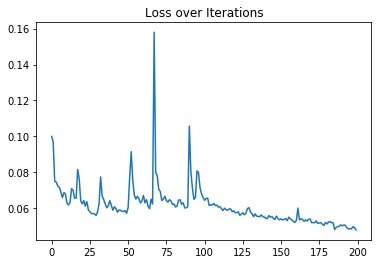

In [14]:
import matplotlib.pyplot as plt
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_title('Loss over Iterations')
ax.plot(history_of_loss)
fig.canvas.draw()
plt.show()

In [ ]:
print (len(histroy_of_roc))

In [ ]:
X_test, T_test = shuffleXY(X_val, T_val)
X_t = construct_X(seqs_dict, X_test, cutoff, n_gram_size, dimension, 2000, 0)
T_t = np.array(T_test[0: 2000]).reshape(2000,cutoff,1)
x_t,y_t = randomSample(X_t, T_t)
output = model.predict(x_t)
print ('Min ', np.min(output[0]),'Max ',np.max(output[0]))

In [ ]:
for i in range(cutoff):
    if y_t[0][i] == 1:
        print (i, output[0][i])

In [ ]:
print (output.ravel() > 0)